# Fetch catch trials data

In [1]:
import pingouin as pg

import matplotlib.pyplot as plt

from scripts.utils import *
from scripts.stats import *
from funcs.plots import Fig4p50

In [2]:
data_path = get_path('dataframes')

### Collect catch trial data from all experiments

In [3]:
# Get the list of participants
participants = exclude_participants(os.listdir(get_path('raw_data')))

# Define the DataFrame to hold participant data
all_responses = pd.DataFrame()

# Iterate over all participant folders
for participant in participants:
    print("\n---------------", participant.upper(), "---------------")

    # Loop through the paradigms and collect data for each participant
    for paradigm in ['Cluster', 'Continuous', 'Bayesian']:
        print("  -", paradigm)
        paradigm_data = fetch_paradigm_raw_data(participant, paradigm, use_all_available_data=True)

        if paradigm == 'Continuous':

            # Shift all answers to the previous trial
            paradigm_data['responses'] = paradigm_data['responses'].shift(-1)

            # Remove last trial
            paradigm_data = paradigm_data.drop(paradigm_data.index[-1])

        all_responses = pd.concat([all_responses, paradigm_data])



--------------- TLVJDS ---------------
  - Cluster

  -  Processing: tlvjds_Cluster_2022-05-06_11h58.32.052_1.csv
   *** New exp file ***
-----
  - Continuous

  -  Processing: tlvjds_Continuous_2022-05-06_11h41.50.914_1.csv
   *** New exp file ***
-----
  - Bayesian

  -  Processing: tlvjds_Bayesian_2022-05-06_11h12.28.510.csv

--------------- NLHGLM ---------------
  - Cluster

  -  Processing: nlhglm_Cluster_2022-05-09_14h49.52.594_1.csv
   *** New exp file ***
-----
  - Continuous

  -  Processing: nlhglm_Continuous_2022-05-09_15h57.08.063_1.csv
   *** Resumed exp file***
-----

  -  Processing: nlhglm_Continuous_2022-05-09_15h54.07.920_1.csv
   *** Resumed exp file***
-----

  -  Processing: nlhglm_Continuous_2022-05-09_15h45.26.215_1.csv
   *** New exp file ***
-----
  - Bayesian

  -  Processing: nlhglm_Bayesian_2022-05-09_14h42.58.204.csv

--------------- KLXUFM ---------------
  - Cluster

  -  Processing: klxufm_Cluster_2022-05-09_16h56.39.686_1.csv
   *** New exp file ***
-

### Do some clean-up

In [4]:
# Remove rows not corresponding to trials
all_responses = all_responses[~all_responses.isCatchTrial.isnull()]

# Select columns
all_responses = all_responses[['participant', 'paradigm', 'pred',
                               'isCatchTrial', 'responses', 'feedback.rt', 'trials.thisN']]

# Fix some data format issues
all_responses.isCatchTrial = all_responses.isCatchTrial.astype(bool)

all_responses.responses = all_responses.responses.astype(object)
all_responses['responses'] = all_responses['responses'].apply(lambda x: 0 if (x == 'None') or (pd.isnull(x)) else 1)

all_responses.loc[all_responses.paradigm == 'Bayesian', 'pred'] = 'bayesian'

# Display the first rows
all_responses.head()

,participant,paradigm,pred,isCatchTrial,responses,feedback.rt,trials.thisN
9,tlvjds,Cluster,both,False,1,[0.32247939996887],0.0
10,tlvjds,Cluster,time,False,1,[0.4047361999982968],1.0
11,tlvjds,Cluster,frequency,False,1,[0.32659319997765124],2.0
12,tlvjds,Cluster,none,True,1,[0.1770447000162676],3.0
13,tlvjds,Cluster,frequency,False,1,[0.4016340000089258],4.0


### Compute false alarm rates

In [5]:
def calculate_false_alarm_rate(group):
    group['false_alarm_rate'] = group['responses'].sum() / len(group)
    group['nCatchTrials'] = len(group)
    return group

catch_trials = all_responses[all_responses.isCatchTrial]

# Add column with false alarm rates
catch_trials = catch_trials.groupby(['participant', 'paradigm', 'pred']).apply(calculate_false_alarm_rate)


### Descriptive stats

In [6]:
FAR = catch_trials[['participant', 'paradigm', 'pred', 'false_alarm_rate']].drop_duplicates()

FAR.groupby(['paradigm', 'pred']).false_alarm_rate.describe()

count      mean       std  min       25%       50%  \
paradigm   pred                                                            
Bayesian   bayesian    28.0  0.017363  0.047050  0.0  0.000000  0.000000   
Cluster    both        28.0  0.138486  0.147954  0.0  0.000000  0.108187   
           frequency   28.0  0.161256  0.186996  0.0  0.000000  0.105556   
           none        28.0  0.159449  0.146078  0.0  0.000000  0.133929   
           time        28.0  0.170022  0.154999  0.0  0.046875  0.154762   
Continuous both        28.0  0.162968  0.141666  0.0  0.000000  0.142857   
           frequency   28.0  0.092069  0.142826  0.0  0.000000  0.000000   
           none        28.0  0.094487  0.124734  0.0  0.000000  0.000000   
           time        28.0  0.209779  0.179157  0.0  0.000000  0.154762   

                           75%       max  
paradigm   pred                           
Bayesian   bayesian   0.000000  0.222222  
Cluster    both       0.179972  0.500000  
           frequency  0.285714  0.600000  
           none       0.275974  0.500000  
           time       0.250000  0.666667  
Continuous both       0.238095  0.500000  
           frequency  0.166667  0.500000  
           none       0.148810  0.428571  
           time       0.343750  0.555556

### Save catch trial data and false alarm rates

In [7]:
catch_trials.to_pickle(os.path.join(data_path, 'catch_trials.pkl'))
FAR.to_pickle(os.path.join(data_path, 'false_alarm_rates.pkl'))

### Fig4C - False Alarm Rate Barplot

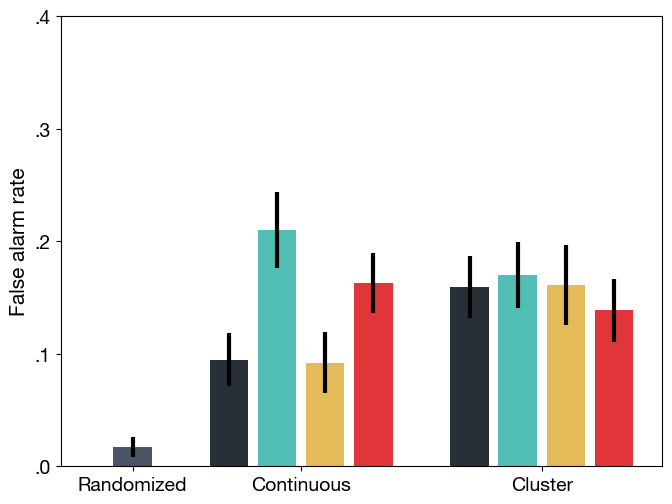

In [8]:
fig = Fig4p50().catch_trials_barplot(FAR)
plt.savefig(os.path.join(get_path('figures'), 'Fig4C-catch_trial_barplot.svg'))

### ANOVA on the False Alarm Rates

In [9]:
stats_params = StatsParams()

In [14]:
# Treat each condition as a separate group
FAR['condition'] = FAR['paradigm'] + FAR['pred'].apply(lambda x: '' if x == 'bayesian' else '/' + translate_conditions(x))

# run one-way ANOVA
aov_results = pg.rm_anova(data=FAR, dv='false_alarm_rate',
                          within='condition', subject='participant')

StatsFormatter().print_1way_anova(StatsFormatter, aov_results, var='false_alarm_rate', factor='condition')

28
0
One-way ANOVA on the false_alarm_rate (factor: condition):
condition: F(8, 216) = 5.78, p = <0.001     *



In [11]:
# post-hoc paired T-tests
pairwise_results = pg.pairwise_tests(data=FAR,
                                     dv='false_alarm_rate',
                                     within='condition',
                                     subject='participant',
                                     alternative='two-sided',
                                     padjust=StatsParams.mult_comp)

# Display post-hoc results
StatsFormatter().print_paired_ttest_posthocs(pairwise_results)

Post-hoc tests (paired t-tests):
condition / Bayesian vs Cluster/F: T(27) = -3.84, p = <0.001 (fdr_bh: 0.004)     *
condition / Bayesian vs Cluster/FT: T(27) = -4.21, p = <0.001 (fdr_bh: 0.002)     *
condition / Bayesian vs Cluster/R: T(27) = -5.00, p = <0.001 (fdr_bh: <0.001)     *
condition / Bayesian vs Cluster/T: T(27) = -5.02, p = <0.001 (fdr_bh: <0.001)     *
condition / Bayesian vs Continuous/F: T(27) = -2.58, p = 0.016 (fdr_bh: 0.047)     *
condition / Bayesian vs Continuous/FT: T(27) = -5.13, p = <0.001 (fdr_bh: <0.001)     *
condition / Bayesian vs Continuous/R: T(27) = -3.15, p = 0.004 (fdr_bh: 0.018)     *
condition / Bayesian vs Continuous/T: T(27) = -5.56, p = <0.001 (fdr_bh: <0.001)     *
condition / Cluster/F vs Cluster/FT: T(27) = 0.56, p = 0.578 (fdr_bh: 0.717)
condition / Cluster/F vs Cluster/R: T(27) = 0.05, p = 0.957 (fdr_bh: 0.967)
condition / Cluster/F vs Cluster/T: T(27) = -0.24, p = 0.812 (fdr_bh: 0.941)
condition / Cluster/F vs Continuous/F: T(27) = 1.64, p = 

In [12]:
aov_results = pg.rm_anova(data=FAR.loc[FAR.paradigm.isin(['Continuous', 'Cluster'])], dv='false_alarm_rate',
                          within=['paradigm', 'pred'], subject='participant')

StatsFormatter().print_2way_anova(StatsFormatter, aov_results, var='false_alarm_rate', factors=['paradigm', 'pred'])

Two-way ANOVA (paradigm, pred) on the false_alarm_rate: 

Source                   F        ddof1  ddof2   p-unc    sig
paradigm                 0.54      1      27     0.468     
pred                     3.41      3      81     0.021     *
paradigm * pred          3.35      3      81     0.023     *



In [13]:
# post-hoc paired T-tests
pairwise_results = pg.pairwise_tests(data=FAR.loc[FAR.paradigm.isin(['Continuous', 'Cluster'])],
                                     dv='false_alarm_rate',
                                     within=['paradigm', 'pred'],
                                     subject='participant',
                                     alternative='two-sided',
                                     padjust=StatsParams.mult_comp)

# Display post-hoc results
StatsFormatter().print_paired_ttest_posthocs(pairwise_results)

Post-hoc tests (paired t-tests):
paradigm / Cluster vs Continuous: T(27) = 0.74, p = 0.468 (fdr_bh: nan)
pred / both vs frequency: T(27) = 0.94, p = 0.357 (fdr_bh: 0.428)
pred / both vs none: T(27) = 1.09, p = 0.287 (fdr_bh: 0.428)
pred / both vs time: T(27) = -2.05, p = 0.050 (fdr_bh: 0.100)
pred / frequency vs none: T(27) = -0.02, p = 0.988 (fdr_bh: 0.988)
pred / frequency vs time: T(27) = -2.49, p = 0.019 (fdr_bh: 0.058)
pred / none vs time: T(27) = -2.62, p = 0.014 (fdr_bh: 0.058)
paradigm * pred / both vs frequency: T(27) = -0.56, p = 0.578 (fdr_bh: 0.866)
paradigm * pred / both vs none: T(27) = -0.71, p = 0.484 (fdr_bh: 0.829)
paradigm * pred / both vs time: T(27) = -1.10, p = 0.283 (fdr_bh: 0.566)
paradigm * pred / frequency vs none: T(27) = 0.05, p = 0.957 (fdr_bh: 0.957)
paradigm * pred / frequency vs time: T(27) = -0.24, p = 0.812 (fdr_bh: 0.957)
paradigm * pred / none vs time: T(27) = -0.32, p = 0.753 (fdr_bh: 0.957)
paradigm * pred / both vs frequency: T(27) = 2.49, p = 0.0

In [16]:
# run one-way ANOVA
aov_results = pg.rm_anova(data=FAR.loc[FAR.paradigm == 'Cluster'], dv='false_alarm_rate',
                          within='pred', subject='participant')

StatsFormatter().print_1way_anova(StatsFormatter, aov_results, var='false_alarm_rate', factor='pred')

One-way ANOVA on the false_alarm_rate (factor: pred):
pred: F(3, 81) = 0.31, p = 0.818

